<a href="https://colab.research.google.com/github/rsadaphule/jhu-aaml/blob/main/Module01_aml_recommender_sadaphule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recommender Systems

In [92]:
from google.colab import drive; drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
TRAIN_FILE_FOLDER = '/content/drive/My Drive/JHU/Advanced Applied ML/Assignments/data/movielens/'

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
import numpy as np
import pandas as pd
import re
from collections import defaultdict

In [95]:
# A subset of the dataset to shorten the pipeline processing
USERS_N = 1000

In [96]:
# read datasets
df_movies = pd.read_csv(TRAIN_FILE_FOLDER + 'movielens_movie.csv')
df_ratings = pd.read_csv(TRAIN_FILE_FOLDER + 'movielens_rating.csv')
df_tag = pd.read_csv(TRAIN_FILE_FOLDER + 'movielens_tag.csv')

df_genome_tags = pd.read_csv(TRAIN_FILE_FOLDER + 'movielens_genome_tags.csv')
df_genome_scores = pd.read_csv(TRAIN_FILE_FOLDER + 'movielens_genome_scores.csv')

In [97]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [98]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [99]:
df_tag.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [100]:
df_genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [101]:
df_genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [102]:
print(f"Number of unique movies= {len(df_movies)}")
print(f"Number of unique users= {len(df_ratings.userId.unique())}")

print(f"Number of unique rated movies= {len(df_ratings.movieId.unique())} (not all movies are rated by users)")

# MovieLens rating system
print(f"Number of tags= {len(df_genome_tags)}")
print(f"Number of tagger users= {len(df_tag.userId.unique())} (who created/assigned tags)")
print(f"Number of created unrefined tags= {len(df_tag.tag.unique())} (created tags, not-refined tags)")

Genres = defaultdict(int)
for genre in df_movies.genres:
    if 'no' not in genre:
        m = re.findall(r"([A-Za-z-]+)(?=\||$)", genre)
        if m:
            for gen in m:
                Genres[gen] += 1

print(f"Number of genres= {len(Genres.keys())}")

Number of unique movies= 27278
Number of unique users= 138493
Number of unique rated movies= 26744 (not all movies are rated by users)
Number of tags= 1128
Number of tagger users= 7801 (who created/assigned tags)
Number of created unrefined tags= 38644 (created tags, not-refined tags)
Number of genres= 19


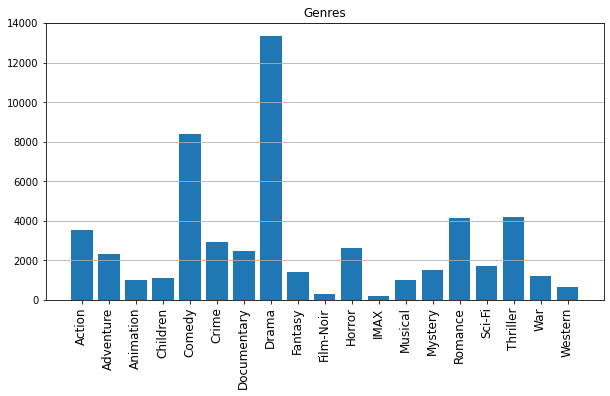

In [103]:
# genres
gens = sorted(Genres.keys())

plt.figure(figsize=(10,5), dpi=72)
plt.bar(gens, [Genres[g] for g in gens])
plt.xticks(rotation=90, fontsize=12)
plt.grid(axis='y')
plt.title('Genres')
plt.show()

In [104]:
# explore ratings data
Rating_Min, Rating_Max = df_ratings.rating.min(), df_ratings.rating.max()
print(Rating_Min, Rating_Max)

0.5 5.0


In [105]:
# movies index
movies = df_ratings.movieId.unique()
MoviesIndex = {mov:i for i, mov in enumerate(movies)}
MoviesIndexRev = {MoviesIndex[mov]:mov for mov in MoviesIndex.keys()}

print(len(MoviesIndex.keys()), len(MoviesIndexRev.keys()))

26744 26744


In [106]:
%%time

# rating matrix N-by-M, users-by-movies

# N = len(df_ratings.userId.unique())
N = USERS_N  # Full problem as above
M = len(MoviesIndex.keys())
Ratings = np.zeros((N,M), dtype=np.float32)

for _, row in df_ratings.iterrows():
    if row.userId > USERS_N:  # Shorten the problem dataset
        break
    Ratings[row.userId-1, MoviesIndex[row.movieId]] = row.rating

CPU times: user 11.6 s, sys: 1.65 s, total: 13.2 s
Wall time: 13.2 s


In [107]:
# remove movies that have min number of ratings from the user list
#RATINGS_N_MIN= 20
RATINGS_N_MIN= 40
#RATINGS_N_MIN= 70 give error



moviesnull = np.where(np.count_nonzero(Ratings, axis=0) <= RATINGS_N_MIN)[0]
moviesnull = [MoviesIndexRev[_] for _ in moviesnull]

print(len(moviesnull))

25814


In [108]:
# movies index
movies = list(set(df_ratings.movieId.unique().tolist()) - set(moviesnull))
MoviesIndex = {mov:i for i, mov in enumerate(movies)}
MoviesIndexRev = {MoviesIndex[mov]:mov for mov in MoviesIndex.keys()}

print(len(MoviesIndex.keys()), len(MoviesIndexRev.keys()))

930 930


In [109]:
# update the rating matrix
M = len(MoviesIndex.keys())
Ratings = np.zeros((N,M), dtype=np.float32)

for _, row in df_ratings.iterrows():
    if row.userId > USERS_N:  # Shorten the problem dataset
        break
    if row.movieId in MoviesIndex:  # Skip low count rated movies
        Ratings[row.userId-1, MoviesIndex[row.movieId]] = row.rating

print(Ratings.shape)  # number of users, number of movies

(1000, 930)


In [110]:
# sanity
moviesnull = np.where(np.count_nonzero(Ratings, axis=0) <= RATINGS_N_MIN)[0]

print(len(moviesnull))

0


In [111]:
# distance metrics

def sim_jaccard(_a:np.ndarray, _b:np.ndarray)->float:
    ix = np.where((_a>0.) & (_b>0.))
    ixd = np.where((_a>0.) | (_b>0.))
    return ix[0].shape[0] / ixd[0].shape[0]

def sim_costeta(_a:np.ndarray, _b:np.ndarray)->float:
    from numpy.linalg import norm
    assert _a.shape == _b.shape, 'require vectors same shape'
    return np.dot(_a, _b) / (norm(_a)*norm(_b))

def sim_pearson(_a:np.ndarray, _b:np.ndarray)->float:
    ix = np.where((_a>0.) & (_b>0.))
    if ix[0].shape[0] == 0:
        return 0.
    _ua, _ub = np.mean(_a[ix]), np.mean(_b[ix])
    num = (_a[ix]-_ua) @ (_b[ix]-_ub).T
    den  = np.sqrt(np.sum((_a[ix]-_ua)**2)) * np.sqrt(np.sum((_b[ix]-_ub)**2))
    if den == 0.:
        return 0.
    return num/den

def dist_L1(_a:np.ndarray, _b:np.ndarray)->float:
    ix = np.where((_a>0.) & (_b>0.))
    if ix[0].shape[0] == 0:
        return 1.
    return np.sum(np.abs(_a[ix]-_b[ix])) / ix[0].shape[0]

def dist_L2(_a:np.ndarray, _b:np.ndarray)->float:
    ix = np.where((_a>0.) & (_b>0.))
    if ix[0].shape[0] == 0:
        return 1.
    return np.sqrt(np.sum((_a[ix]-_b[ix])**2)) / ix[0].shape[0]

def dist_cheby(_a:np.ndarray, _b:np.ndarray)->float:
    ix = np.where((_a>0.) & (_b>0.))
    if ix[0].shape[0] == 0:
        return 1.
    return np.max(_a[ix]-_b[ix]) / (Rating_Max-Rating_Min)

DistanceMetrics = [(sim_jaccard, 'Jaccard (sim)'), (sim_costeta, 'CosTeta (sim)'), (sim_pearson, 'Pearson (sim)'),
                   (dist_L1, 'L1 (dist)'), (dist_L2, 'L2 (dist)'), (dist_cheby, 'Chebyshev (dist)')]

In [112]:
# distances
USER_A, USER_B = 0, 1

x1, x2 = Ratings[USER_A], Ratings[USER_B]

for metric in DistanceMetrics:
    print(f'{metric[1]:<17} {metric[0](x1, x2):.3f}')

Jaccard (sim)     0.066
CosTeta (sim)     0.159
Pearson (sim)     -0.069
L1 (dist)         1.167
L2 (dist)         0.412
Chebyshev (dist)  0.444


In [113]:
Ratings[USER_A]

array([0. , 3.5, 0. , 0. , 0. , 0. , 0. , 3.5, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 3.5, 0. , 0. , 3.5,
       0. , 0. , 0. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. , 0. , 3.5,
       0. , 0. , 3.5, 0. , 4. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 4. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 3.5, 0. , 0. , 0. , 0. , 4. , 0. ,
       3.5, 0. , 0. , 0. , 0. , 0. , 4. , 3.5, 0. , 4. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       4. , 0. , 0. , 0. , 0. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. , 4. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 4. ,
       0. , 4. , 0. , 0. , 0. , 0. , 0. , 0. , 4. , 0. , 0. , 0. , 4. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 4. , 4. , 0. , 0.

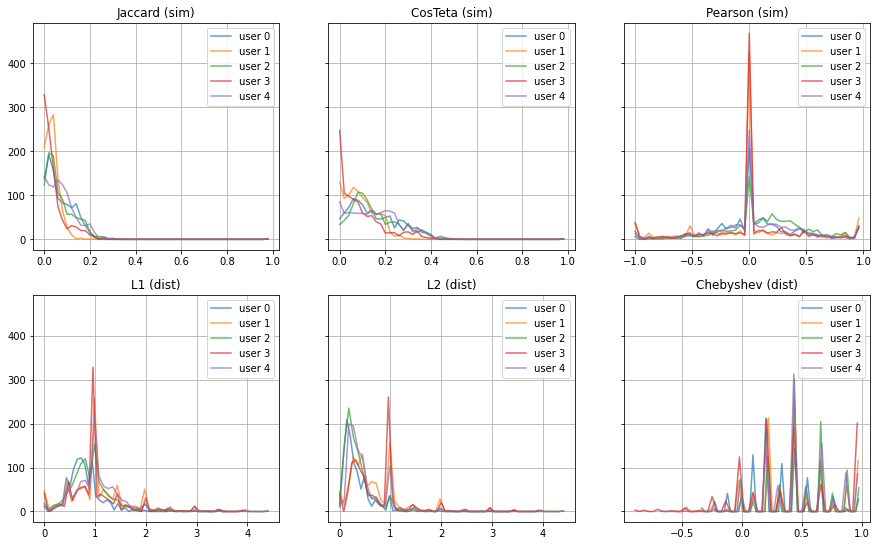

In [114]:
Users = [0, 1, 2, 3, 4]

# example, user Users to other users histogram for these six distance metrics
fig, ax = plt.subplots(nrows=2, ncols=3, sharex='none', sharey='all', figsize=(15, 9), dpi=72)

for i, metric in enumerate(DistanceMetrics):
    for u in Users:
        d = [metric[0](Ratings[u], Ratings[_]) for _ in range(N)]
        h = np.histogram(d, bins=50)
        ax.flatten()[i].plot(h[1][:-1], h[0], label=f'user {u:d}', alpha=0.7)
    ax.flatten()[i].set_title(metric[1])
    ax.flatten()[i].legend(loc='upper right')
    ax.flatten()[i].grid()

## COllaborative Filtering
User-based Example
Find out what a user would score a particular movie that he/she did not score (or watch)
Similarity will be based on users
Use sim_costeta for similarity (can try other ones)
Distance matrix is N-by-N
Always use float32 for speed

In [115]:
# User-based filtering
OUR_USER= 0
OUR_ITEM= 0  # pick an item which our user did not rate
OUR_USER_NEIGHBORHOOD= 50  # number of users similar to our user

In [116]:
# users who rated our item
ix = np.where(Ratings[:,OUR_ITEM]>0.)[0]

In [117]:
%%time

# generate a distance matrix - user
Dist_u = np.zeros((N,N), dtype=np.float32)
for i in range(N):
    for j in range(N):
        Dist_u[i,j] = sim_costeta(Ratings[i,:], Ratings[j,:])

CPU times: user 11.3 s, sys: 66.3 ms, total: 11.4 s
Wall time: 11.3 s


In [118]:
# Pearson generates -1 to +1
d = np.abs(Dist_u[OUR_USER,ix])
ix_best = np.argsort(-d)[:OUR_USER_NEIGHBORHOOD]
users = ix[ix_best]

In [119]:
Dist_u[OUR_USER,users]

array([0.4445874 , 0.4243528 , 0.41530976, 0.41283774, 0.40813935,
       0.40495536, 0.40379223, 0.40312892, 0.40300524, 0.40054035,
       0.3996757 , 0.39455053, 0.3937092 , 0.39204827, 0.3917687 ,
       0.39110366, 0.38725355, 0.38593456, 0.38579038, 0.38183647,
       0.38143834, 0.38026038, 0.37938303, 0.37491086, 0.3747061 ,
       0.37433997, 0.37285253, 0.37021703, 0.36702037, 0.36551723,
       0.36550587, 0.36079073, 0.36063212, 0.35776958, 0.3571221 ,
       0.35515693, 0.35088676, 0.3505999 , 0.35041368, 0.3476264 ,
       0.3461838 , 0.34575626, 0.3445126 , 0.34343147, 0.34292808,
       0.342859  , 0.34196743, 0.34045884, 0.34013277, 0.33981133],
      dtype=float32)

In [120]:
ratings = np.array([Ratings[_,OUR_ITEM] for _ in users])

print(f'The user not rated the item= {Ratings[OUR_USER, OUR_ITEM]:.1f}')
print(f'Average rating in user-neighborhood= {ratings.mean():.1f}')

The user not rated the item= 0.0
Average rating in user-neighborhood= 3.9


Item-based Example
Find out what a user would score a particular movie that he/she did not score (or watch)
Similarity will be based on items
Use sim_costeta for similarity (can try other ones)
Distance matrix is M-by-M
Always use float32 for speed

In [121]:
# Item-based filtering
OUR_USER= 0
OUR_ITEM= 0  # pick an item which our user did not rate
OUR_ITEM_NEIGHBORHOOD= 50  # number of items similar to our item

In [122]:
# users who rated our item
users = np.where(Ratings[:,OUR_ITEM]>0.)[0]

In [123]:
%%time

# generate a distance matrix - item
Dist_i = np.zeros((M,M), dtype=np.float32)
for i in range(M):
    for j in range(M):
        Dist_i[i,j] = sim_costeta(Ratings[:,i], Ratings[:,j])

CPU times: user 16.5 s, sys: 29.3 ms, total: 16.5 s
Wall time: 16.5 s


In [124]:
d = np.abs(Dist_i[OUR_ITEM,:])
ix_best = np.argsort(-d)[:OUR_ITEM_NEIGHBORHOOD]
items = ix_best

In [125]:
ratings = np.array([Ratings[users,_] for _ in items])

print(f'The user not rated the item= {Ratings[OUR_USER, OUR_ITEM]:.1f}')
print(f'Average rating in item-neighborhood= {ratings.mean():.1f}')

The user not rated the item= 0.0
Average rating in item-neighborhood= 1.8



Cluster the Items
Item category can help a user to select a relevant item. In addition, the user selections and scores can guide the recommender system to predict what category a user likes more than the others. Creating item genres or item categories can be accomplished via clustering item features. These features can be also some augmented information provided by experts (or even movie critics). In this example, we can use movie titles (plots, information extracted from Web, or even parsing movie scripts) to create a movie feature vector. Note that in our dataset there are also tags which capture this kind of information.

Use the following two resources:

gensim GloVe Gensim = "Generate Similar" is a topic modeling library to implement Latent Semantic Methods and it is licensed under GNU LGPLv2.1 license
GloVe embedding model with feature size M=50 using https://nlp.stanford.edu/projects/glove/
gensim library can download GloVe word embeddings to be used as word vectors in text processing. A movie is represented by its title and the average of the word vectors it constitutes (Word2Vec is another method to represent a text phrase).

GloVe project is an embedding approach trained by very large corpora and specifically indexed words in a consistent manner in order to improve sharing across problems and domains. The selected embedding is M=50 dimensions, 400K words.

The number of genres might be a good starting point as the number of clusters expected.

Let's represent each movie by its average word embedding extracted from its title and cluster.


In [126]:
import gensim
import gensim.downloader

print(f'gensim version= {gensim.__version__}')
Glove = gensim.downloader.load('glove-wiki-gigaword-50')

GLOVE_M = 50

gensim version= 4.3.1


In [127]:
# restart movie index due to filtering as in the previous Cells
movies = sorted(df_ratings.movieId.unique())
MoviesIndex = {mov:i for i, mov in enumerate(movies)}
MoviesIndexRev = {MoviesIndex[mov]:mov for mov in MoviesIndex.keys()}

M_titles = len(MoviesIndex.keys())
print(len(MoviesIndex.keys()), len(MoviesIndexRev.keys()))

26744 26744


In [128]:
M_titles

26744

In [129]:
# populate titles, extract tokens
Titles, TitleGenres, TitlesParsed = [None]*M_titles, [None]*M_titles, [None]*M_titles
for _, row in df_movies.iterrows():
    if row.movieId in MoviesIndex:
        Titles[MoviesIndex[row.movieId]] = row.title
        TitleGenres[MoviesIndex[row.movieId]] = re.search(r'[\w\-]+', row.genres).group(0)  # use only the first one

for _, title in enumerate(Titles):
    TitlesParsed[_] = re.findall(r'[a-z]+', title.lower())

# sanity
print(Titles[:5])
print(TitlesParsed[:5])
print(TitleGenres[:5])

['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)', 'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)']
[['toy', 'story'], ['jumanji'], ['grumpier', 'old', 'men'], ['waiting', 'to', 'exhale'], ['father', 'of', 'the', 'bride', 'part', 'ii']]
['Adventure', 'Adventure', 'Comedy', 'Comedy', 'Comedy']


In [130]:
# take the average word vectors to represent titles in GloVe embeddings
X = np.zeros((M_titles, GLOVE_M), dtype=np.float32)
for _, title in enumerate(TitlesParsed):
    v = []
    if len(title) == 0:
        # movie title empty after parsing, setting to zero vector
        X[_] = np.zeros(GLOVE_M, dtype=np.float32)
    else:
        for w in title:
            v += [Glove[w]] if w in Glove else [np.zeros(GLOVE_M, dtype=np.float32)]
        X[_] = np.mean(np.array(v), axis=0)

In [131]:
from sklearn.cluster import KMeans

# use number of genres to cluster
K = len(Genres.keys())
Clusters = KMeans(n_clusters=K, n_init=10).fit_predict(X)

In [132]:
# Print a few movie titles and their cluster IDs in a genre
GENRE = 'Horror'
n_results = 20
for _, g in enumerate(TitleGenres):
    if g == GENRE and n_results > 0:
        print(f'{Clusters[_]:2d}  {Titles[_]:s}')
        n_results -= 1

13  Lord of Illusions (1995)
11  Species (1995)
13  Castle Freak (1995)
 1  Relative Fear (1994)
13  Tales from the Crypt Presents: Demon Knight (1995)
14  Village of the Damned (1995)
 1  Fear, The (1995)
14  In the Mouth of Madness (1995)
13  Body Snatchers (1993)
13  Puppet Masters, The (1994)
 9  301, 302 (301/302) (1995)
10  Cemetery Man (Dellamorte Dellamore) (1994)
11  Thinner (1996)
14  Spirits of the Dead (1968)
 5  Eyes Without a Face (Yeux sans visage, Les) (1959)
13  Relic, The (1997)
 4  Halloween: The Curse of Michael Myers (Halloween 6: The Curse of Michael Myers) (1995)
14  Night of the Living Dead (1968)
14  Children of the Corn IV: The Gathering (1996)
16  Fog, The (1980)


Question: How do you assess the performance of this clustering?

Ans: The performance of this clustering can be measured in multiple ways
1. Vary the Cluster Size and pefform human hudgement and ask humans to rate tne K nearast neighbor for each cluster size
2. Silhoutte Score: This is a metric used to calculate the goodness of a clustering algorithm. Its value ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
3. WCSS (Within-cluster sum of squares) - This is the sum of squared distances of samples to their closest cluster center. A lower inertia value is better, but it tends to decrease as the number of clusters increases. So, it's essential to find a balance.
4. Visual Inspection: For a lower-dimensional space (like 2D or 3D), we can visually inspect the clusters using scatter plots. However, given that the embeddings are in 50D space, dimensionality reduction techniques like t-SNE or PCA can be used to visualize the data in 2D or 3D.

Question: Do you expect above clustering will work on titles for other genres?
  

1.   It may work well for few items but not for all. It will work well for genres on which we have good volume of data but may not work well on gneres we=here data is sparse.  we need to try it our to see how well it works. We need to visually inspect and compute few metrics as mentioned above.

2.   The current approach only considers the first genre if a movie belongs to multiple genres. This simplification might not always be representative, especially for movies that blend genres.

3. For some genres, the titles might be indicative. For instance, horror movies might have words like "haunting," "ghost," "nightmare," etc., which could cluster well. However, for genres like drama or comedy, the titles might be more varied and less indicative of the genre, making clustering less effective.






Exercises
Exercise 1. Reduce the number of items by updating the minimum number of ratings and rerun the analysis.

Ans:  Lets change the RATINGS_N_MIN to 40 from 20. I have done that change in the code and reran the notebook.  This will get us ratings matrix ith a subset of movies that have a higher number of ratings, which can potentially improve the clustering results

 |RATINGS_N_MIN | User Based Rating   |  Item Based Rating | Horror Collection CLuster |
 |--------------|:--------------------|-------------------- |---------------- |
 |20            |     3.9             |     1.8             | Accuracy : 19/20
 |40            |     3.9             |     1.8              |Accuracy : 19/20
 |>=50.         | Lots of errors in the code


Summary: Changing RATINGS_N_MIN to 50 does reduce number of movies in rathings dataset to 486. But it does not change average rating by using User Based fiktering or Item based filterig nor it changes accuracy of gensim algorithm

Exercise 2. Why the item filtering revealed a much lower rating compared to the user?

And:


1.   the user-item matrix is sparse. This means that many users have rated only a few items. When I filter out items (movies) based on a minimum number of ratings, I might be removing a significant portion of the data, leading to a loss of information.
2.   Filtering items based on the number of ratings can introduce a bias towards popular items. While these items might have many ratings, they might not necessarily have high ratings. This can skew the average rating downwards.
3. New movies or items that haven't accumulated enough ratings yet might be filtered out, even if they have the potential to be highly rated in the future.


How do you remedy?
Ans:


1.   Use additional metadata (like movie genres, tags, or summaries) to enhance the recommendation. This can provide more context and improve the quality of recommendations, especially when the number of ratings is limited
2.   I have tried Experimenting with different thresholds for the minimum number of ratings. That did not work. Instead of a fixed number, I may have to consider using a dynamic threshold based on the distribution of ratings
3. I may consider content-based filtering, where recommendations are based on item attributes rather than user-item interactions.





Exercise 3. Implement content based filtering by generating similarities between movies based on their tags.

Content-based filtering recommends items by comparing the content of the items and a user profile, with content being described in terms of metadata of the movie (e.g., a movie's tags or genres). The similarities between items are then calculated based on these descriptors.

In [133]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [135]:
# Merging tags with movies
df_tags_merged = df_tag.groupby('movieId')['tag'].apply(lambda x: ' '.join(map(str, x))).reset_index()
df_movies_tags = pd.merge(df_movies, df_tags_merged, on='movieId', how='left')
df_movies_tags['tag'].fillna('', inplace=True)


In [136]:
#compute tf-idf matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_movies_tags['tag'])

In [137]:
# compute similarity score
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [141]:
#This function will take a movie title as input and return a list of movies that are most similar to it based on their tags.
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = df_movies_tags.index[df_movies_tags['title'] == title].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get scores of the 10 most similar movies
    movie_indices = [i[0] for i in sim_scores]
    return df_movies_tags['title'].iloc[movie_indices]



In [142]:
# Let's get simiarity score
print(get_recommendations('Toy Story (1995)'))

3027             Toy Story 2 (1999)
2270           Bug's Life, A (1998)
4790          Monsters, Inc. (2001)
5121                 Ice Age (2002)
6271            Finding Nemo (2003)
15401            Toy Story 3 (2010)
11614            Ratatouille (2007)
8278        Incredibles, The (2004)
21168    Monsters University (2013)
13767                     Up (2009)
Name: title, dtype: object


# Assignment 1

1.[20 pts] Build a genome vector, score, and then list the top Batman movies using similarity
metrics. Note that we will not use any text processing on the movie title but rather similarity
vectors. Create a single similarity vector for Batman movies to be compared to other
genome vectors. One should use a distance measure between the Batman movies genome
vector and the other movies genome vectors. Use any approach as you see fit.
2. [20 pts] List top-10 users who love (or scored high) Batman movies using the genome
vectors. Using the built pipeline find out the second loved movie for these 10 users.
3. [20 pts] Find out the single best genre representing Batman movies. The genre is listed in
the movie dataset next to the movie title.
4. [20 pts] Utilize the user tags to build item vectors for clustering. Same approach with GloVe
word embeddings can be used.
5. [20 pts] Find out how much the two clustering approaches in the module and (Q4.) come
close to the correct representation of the genres of the movies. The genres can also be
represented as the average word vectors based on genre terms. Note that the module uses
only the first term in the genre. A 2D visualization using PCA could help how these three
representations compare (title word embeddings, tag word embeddings, and genre word
embeddings).


1. [20 pts] Build a genome vector, score, and then list the top Batman movies using similarity metrics. Note that we will not use any text processing on the movie title but rather similarity vectors. Create a single similarity vector for Batman movies to be compared to other genome vectors. One should use a distance measure between the Batman movies genome vector and the other movies genome vectors. Use any approach as you see fit.

In [144]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Merge genome scores with genome tags
df_genome = pd.merge(df_genome_scores, df_genome_tags, on='tagId')

# Filter out Batman movies
batman_movies = df_movies[df_movies['title'].str.contains('Batman', case=False)]
batman_movie_ids = batman_movies['movieId'].tolist()

# Create a genome matrix where rows are movies and columns are genome tags
genome_matrix = df_genome.pivot(index='movieId', columns='tag', values='relevance')

# Filter out Batman movie IDs that are present in the genome_matrix
valid_batman_movie_ids = [movie_id for movie_id in batman_movie_ids if movie_id in genome_matrix.index]

# Create a single genome vector for Batman movies by averaging the genome scores
batman_genome_vector = genome_matrix.loc[valid_batman_movie_ids].mean().values.reshape(1, -1)

# Compute the cosine similarity between the Batman genome vector and all other movies
similarities = cosine_similarity(batman_genome_vector, genome_matrix)

# Rank movies based on their similarity to Batman movies
sorted_indices = np.argsort(similarities[0])[::-1]
top_movies = df_movies.set_index('movieId').loc[genome_matrix.index[sorted_indices]]

# Display the top Batman-like movies
print(top_movies['title'].head(10))



movieId
3213                Batman: Mask of the Phantasm (1993)
98124    Batman: The Dark Knight Returns, Part 1 (2012)
27311         Batman Beyond: Return of the Joker (2000)
592                                       Batman (1989)
27155                 Batman/Superman Movie, The (1998)
79274                 Batman: Under the Red Hood (2010)
90603                           Batman: Year One (2011)
99813    Batman: The Dark Knight Returns, Part 2 (2013)
33794                              Batman Begins (2005)
60979                      Batman: Gotham Knight (2008)
Name: title, dtype: object


2. [20 pts] List top-10 users who love (or scored high) Batman movies using the genome vectors. Using the built pipeline find out the second loved movie for these 10 users.

In [146]:
# 1. Identify the genome vector for Batman movies
valid_batman_movie_ids = [movie_id for movie_id in batman_movie_ids if movie_id in genome_matrix.index]
batman_genome_vector = genome_matrix.loc[valid_batman_movie_ids].mean().values.reshape(1, -1)

# 2. Calculate the average rating for Batman movies for each user
batman_ratings = df_ratings[df_ratings['movieId'].isin(valid_batman_movie_ids)]
avg_batman_ratings = batman_ratings.groupby('userId')['rating'].mean()

# 3. Rank users based on their average rating for Batman movies
top_users = avg_batman_ratings.sort_values(ascending=False).head(10).index.tolist()

# 4. For the top-10 users, identify their second highest-rated movie
second_loved_movies = []
for user in top_users:
    user_ratings = df_ratings[df_ratings['userId'] == user].sort_values(by='rating', ascending=False)
    second_loved_movie_id = user_ratings.iloc[1]['movieId']
    second_loved_movie_title = df_movies[df_movies['movieId'] == second_loved_movie_id]['title'].values[0]
    second_loved_movies.append(second_loved_movie_title)

print("Top-10 users who love Batman movies and their second loved movie:")
for i, (user, movie) in enumerate(zip(top_users, second_loved_movies)):
    print(f"{i+1}. User {user}: {movie}")


Top-10 users who love Batman movies and their second loved movie:
1. User 121887: Little Mermaid, The (1989)
2. User 100645: Shaun of the Dead (2004)
3. User 121315: One Flew Over the Cuckoo's Nest (1975)
4. User 100589: O Brother, Where Art Thou? (2000)
5. User 22600: Office Space (1999)
6. User 37045: City of Lost Children, The (Cité des enfants perdus, La) (1995)
7. User 7619: Tombstone (1993)
8. User 16667: Batman: The Dark Knight Returns, Part 1 (2012)
9. User 76478: Saving Private Ryan (1998)
10. User 121239: Total Recall (1990)


3. [20 pts] Find out the single best genre representing Batman movies. The genre is listed in the movie dataset next to the movie title.

In [145]:
# Filter out Batman movies
batman_movies = df_movies[df_movies['title'].str.contains('Batman', case=False)]

# Extract and count genres
genre_counts = batman_movies['genres'].str.split('|').explode().value_counts()

# Identify the genre with the highest frequency
best_genre = genre_counts.idxmax()
print(f"The best genre representing Batman movies is: {best_genre}")


The best genre representing Batman movies is: Action


4. [20 pts] Utilize the user tags to build item vectors for clustering. Same approach with GloVe word embeddings can be used.

In [147]:
import gensim.downloader
from sklearn.cluster import KMeans

# 1. Merge the tags with movies
df_tags_merged = df_tag.groupby('movieId')['tag'].apply(lambda x: ' '.join(map(str, x))).reset_index()
df_movies_tags = pd.merge(df_movies, df_tags_merged, on='movieId', how='left')
df_movies_tags['tag'].fillna('', inplace=True)

# 2. Tokenize and preprocess the tags
df_movies_tags['tag_tokens'] = df_movies_tags['tag'].str.lower().str.split()

# 3. Embed the tags using GloVe
Glove = gensim.downloader.load('glove-wiki-gigaword-50')
GLOVE_M = 50

def embed_tags(tags):
    vectors = [Glove[tag] for tag in tags if tag in Glove]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(GLOVE_M)

df_movies_tags['tag_vector'] = df_movies_tags['tag_tokens'].apply(embed_tags)

# Convert the tag vectors into a matrix format for clustering
tag_matrix = np.vstack(df_movies_tags['tag_vector'].values)

# 4. Cluster the movies based on the embedded tags
K = len(df_movies['genres'].str.split('|').explode().unique())
Clusters = KMeans(n_clusters=K, n_init=10).fit_predict(tag_matrix)

df_movies_tags['cluster'] = Clusters


[20 pts] Find out how much the two clustering approaches in the module and (Q4.) come close to the correct representation of the genres of the movies. The genres can also be represented as the average word vectors based on genre terms. Note that the module uses only the first term in the genre. A 2D visualization using PCA could help how these three representations compare (title word embeddings, tag word embeddings, and genre word embeddings).

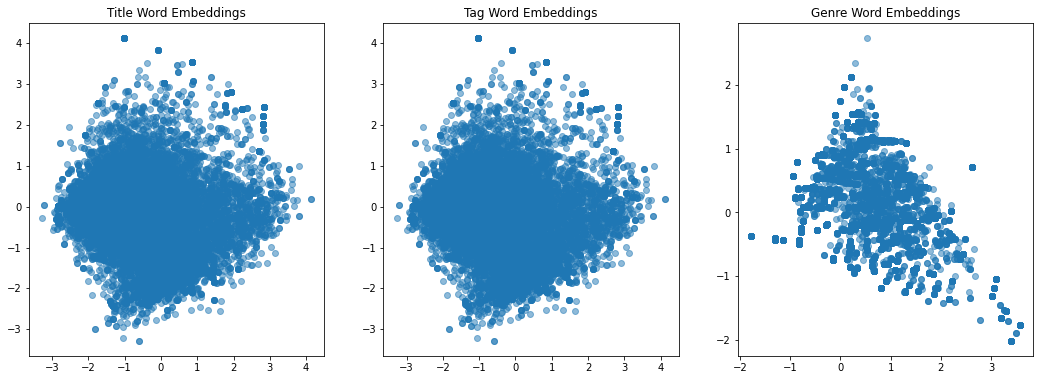

In [148]:
import gensim.downloader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load GloVe embeddings
Glove = gensim.downloader.load('glove-wiki-gigaword-50')

# 1. Embed the genres
def embed_genres(genres):
    genre_tokens = genres.split('|')
    vectors = [Glove[genre.lower()] for genre in genre_tokens if genre.lower() in Glove]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(GLOVE_M)

df_movies['genre_vector'] = df_movies['genres'].apply(embed_genres)

# Convert the genre vectors into a matrix format for PCA
genre_matrix = np.vstack(df_movies['genre_vector'].values)

# 2. Perform PCA
pca = PCA(n_components=2)

title_pca = pca.fit_transform(tag_matrix)
tag_pca = pca.fit_transform(np.vstack(df_movies_tags['tag_vector'].values))
genre_pca = pca.fit_transform(genre_matrix)

# 3. Visualize the embeddings
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(title_pca[:, 0], title_pca[:, 1], alpha=0.5)
plt.title('Title Word Embeddings')

plt.subplot(1, 3, 2)
plt.scatter(tag_pca[:, 0], tag_pca[:, 1], alpha=0.5)
plt.title('Tag Word Embeddings')

plt.subplot(1, 3, 3)
plt.scatter(genre_pca[:, 0], genre_pca[:, 1], alpha=0.5)
plt.title('Genre Word Embeddings')

plt.show()


Analysis:


*   Tag word embeddings  and Title embeddings  are denser as compared to Genre word embeddings
*   The number of vectors in Tag and are title are much more as compared to Genre. This means we'll be able to get more accurate nearest neighbor movie when we use Tag and title as compared to genres.
* In the code we just used first genre of each movie. If we can average the mebddings of all genres in the movie, we might get better more accurate latent genre representations in form of word embeddings.

